In [17]:
%matplotlib inline

import datetime as dt
import itertools as it
import numpy as np
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import seaborn as sns
import synapseclient
from synapseclient import Activity, Schema, Table, as_table_columns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
import scipy.stats as stats
from tqdm import tqdm

init_notebook_mode(connected=True)
InteractiveShell.ast_node_interactivity = 'all'
syn = synapseclient.Synapse()
syn.login()

sidmap = pd.read_csv('sidmap.csv').iloc[:11]

def hours_into_day(x):
    a = dt.datetime(year=x.year, month=x.month, day=x.day, hour=0, minute=0, second=0)
    return (x-a).total_seconds()/3600

Welcome, Luke Waninger!



In [2]:
meta = syn.tableQuery('select participant_id, zipcode from syn17023349').asDataFrame()
participants = meta.participant_id.tolist()

In [3]:
sidmap

,Data,V1,V1Ext,V2,V2Ext,Final
0,PHQ-2,syn10250486,xls,syn9974012,csv,syn17020855
1,AUDIT-C,syn10250481,xls,syn9974011,csv,syn17021280
2,HealthApplications,syn10250489,xls,syn9974014,csv,syn17022426
3,GAD-7,syn10250488,xls,syn9974013,csv,syn17022655
4,SDS,syn10250493,xls,syn9974021,csv,syn17022658
5,Sleep,syn10250494,xls,syn9974022,csv,syn17022659
6,MHServices,syn10250490,xls,syn9974017,csv,syn17022660
7,Mood,syn10250491,xls,syn9974019,csv,syn17023313
8,MHScreening,syn10250487,xls,syn9974018,csv,syn17023316
9,OtherMobileApps,syn10250483,xls,NaN,NaN,syn17025058


### Data load

In [4]:
v1data = {
    t.Data:pd.read_excel(syn.get(t.V1).path) 
    for t in sidmap.itertuples()
}

In [5]:
for k, df in v1data.items():
    v1data[k] = df.rename(columns={
        'response_local':'timestamp',
        'response_utc':'timestampUTC'
    })
    
    v1data[k] = v1data[k]\
        .reindex(columns=[
            'brightenid', 'timestamp', 'timestampUTC'
        ])\
        .rename(columns={
            'brightenid':'participant_id'
    })

In [6]:
utc_control, local_control = [], []
for k, df in v1data.items():
    if 'timestampUTC' in df.columns:
        # make sure to only use US participants
        df = df.loc[[t.participant_id in participants for t in df.itertuples()]]
        utc_control += df.timestampUTC.apply(lambda x: x.hour).tolist()
        local_control += df.timestamp.apply(lambda x: x.hour).tolist()

In [7]:
v2data = {
    t.Data:pd.read_csv(syn.get(t.V2).path, parse_dates=['createdAt']) 
    for t in sidmap.itertuples() if pd.notna(t.V2)
}

In [8]:
for k, v in v2data.items():    
    v2data[k] = v2data[k]\
        .rename(columns={
            'username':'participant_id',
            'createdAt':'timestampUTC'
        })\
        .reindex(columns=[
            'participant_id', 'timestampUTC'
    ])

In [9]:
complete = {}
for t in sidmap.itertuples():
    df = syn.tableQuery(f'select * from {t.Final}').asDataFrame()
    complete[t.Data] = df.reindex(columns=['participant_id', 'dt_response'])

## Visualize

### Plot the completed tables by splitting V1 and V2 by participant ids

<Figure size 432x288 with 0 Axes>

Text(0.5,1,'PHQ-2')

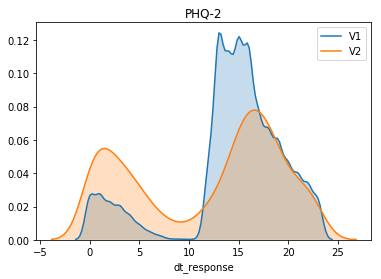

<Figure size 432x288 with 0 Axes>

Text(0.5,1,'AUDIT-C')

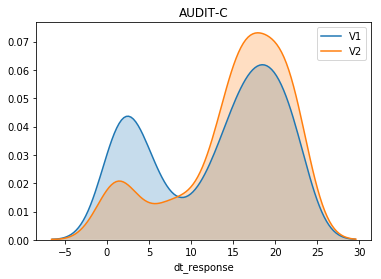

<Figure size 432x288 with 0 Axes>

Text(0.5,1,'HealthApplications')

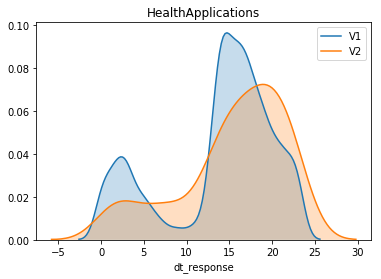

<Figure size 432x288 with 0 Axes>

Text(0.5,1,'GAD-7')

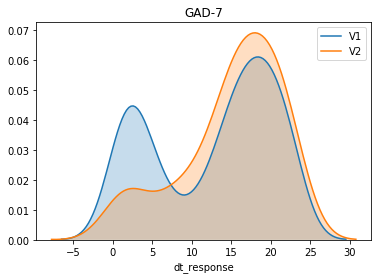

<Figure size 432x288 with 0 Axes>

Text(0.5,1,'SDS')

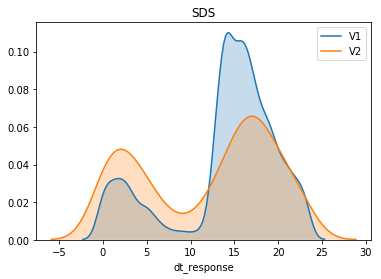

<Figure size 432x288 with 0 Axes>

Text(0.5,1,'Sleep')

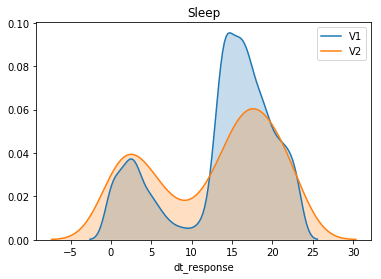

<Figure size 432x288 with 0 Axes>

Text(0.5,1,'MHServices')

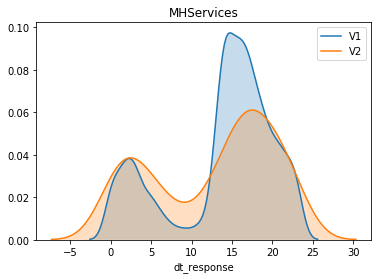

<Figure size 432x288 with 0 Axes>

Text(0.5,1,'Mood')

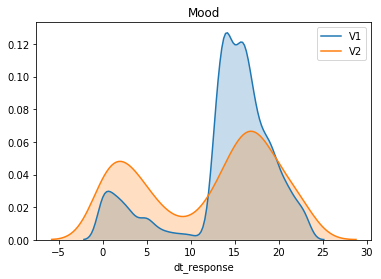

<Figure size 432x288 with 0 Axes>

Text(0.5,1,'MHScreening')

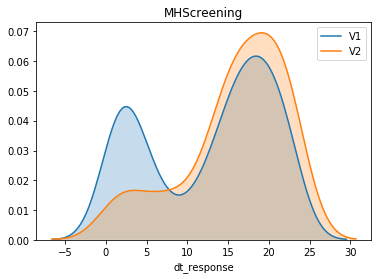

In [21]:
for table_name, df in complete.items():
    df['v2mask'] = [c.startswith('EN') for c in df.participant_id]
    
    if df.v2mask.sum() == 0:
        continue
    
    v1 = pd.to_datetime(df.loc[~df.v2mask].dt_response).apply(lambda x: x.hour)
    v2 = pd.to_datetime(df.loc[df.v2mask].dt_response).apply(lambda x: x.hour)
    df = pd.DataFrame([v1, v2])
#     fig = ff.create_distplot([v1, v2], ['v1', 'v2'], show_hist=False, show_rug=False)
#     fig['layout'].update(dict(
#         title=table_name,
#         xaxis=dict(title='Hour of day')
#     ))
#     iplot(fig)
    plt.gcf()
    sns.distplot(v1, hist=False, kde=True, kde_kws={"shade": True}, label='V1')
    sns.distplot(v2, hist=False, kde=True, kde_kws={"shade": True}, label='V2')
    plt.title(table_name)
    plt.show()

### Plot comparisons of raw v1 vs v2 data

In [12]:
# these are ok
ok = [
    
]
for v in sidmap.dropna(how='any', axis=0).itertuples():
    if v.Data == 'PHQ-9' or v.Data in ok:
        continue
        
    data = [
        pd.to_datetime(v1data[v.Data].timestamp).apply(lambda x: x.hour),
        pd.to_datetime(v1data[v.Data].timestampUTC).apply(lambda x: x.hour),
        pd.to_datetime(v2data[v.Data].timestampUTC).apply(lambda x: x.hour),
    ]
    labels = ['v1-local', 'v1-utc', 'v2']#, 'final']
    fig = ff.create_distplot(data, labels, show_hist=False, show_rug=False)
    fig['layout'].update(dict(
        title=f'{v.Data}',
        xaxis=dict(title='Hour of day')
    ))
    iplot(fig)

### Compare with final table data

In [13]:
data = list(it.chain.from_iterable([[
    #[v1data[v.Data].timestampUTC.apply(lambda x: x.hour).tolist(),
    #v2data[v.Data].createdAt.apply(lambda x: x.hour).tolist(),
    (v.Data, pd.to_datetime(complete[v.Data].dt_response).apply(lambda x: x.hour).tolist())]
    for v in sidmap.dropna(how='any', axis=0).itertuples() if v.Data != 'PHQ-9'      
]))

labels = [data[i][0] for i in range(len(data))] + ['local_control', 'utc_control']
data = [data[i][1] for i in range(len(data))] + [local_control, utc_control]
fig = ff.create_distplot(data, labels, show_hist=False, show_rug=False)

iplot(fig)

## Compare timestamps from raw and final

In [14]:
for data in sidmap.itertuples():
    if data.Data == 'PHQ-9':
        continue
        
    df = complete[data.Data].rename(columns={'dt_response':'final'})
    df['date'] = pd.to_datetime(df.final).apply(lambda x: x.date())

    try:
        comb = pd.concat(
            [
                v1data[data.Data].drop(columns=['timestamp']).rename(columns={'timestampUTC':'raw'}), 
                v2data[data.Data].rename(columns={'timestampUTC':'raw'})
            ], 
            axis=0, 
            sort=False)
    except KeyError:
        comb = v1data[data.Data].rename(columns={'timestampUTC':'raw'})
        
    comb['date'] = pd.to_datetime(comb.raw).apply(lambda x: x.date())

    df = pd.merge(
        df, comb, 
        on=['participant_id', 'date'], 
        how='left').drop(columns=['date', 'hour'], errors='ignore')
    
    df = df.sort_values(by=['participant_id', 'final', 'raw'])
    df = df.loc[[not b for b in df.duplicated(subset='participant_id')]]
    
    df.final = df.final.apply(lambda x: x[:x.find('+')])
    df.final = pd.to_datetime(df.final).apply(lambda x: dt.datetime(
        year=x.year, month=x.month, day=x.day, hour=x.hour
    ))
    df.raw = pd.to_datetime(df.raw).apply(lambda x: dt.datetime(
        year=x.year, month=x.month, day=x.day, hour=x.hour
    ))
    
    df['check'] = pd.to_datetime(df.final) == pd.to_datetime(df.raw)

    if sum(df.check) != len(df):
        print()
        print(data.Data)
        print(df.loc[~df.check])
        print()
    else:
        print(f'{data.Data} is OK')    

PHQ-2 is OK
AUDIT-C is OK
HealthApplications is OK
GAD-7 is OK
SDS is OK

Sleep
    participant_id               final  v2mask                 raw  check
324     BLUE-00239 2015-05-04 15:00:00   False 2015-05-04 16:00:00  False

MHServices is OK
Mood is OK
MHScreening is OK
OtherMobileApps is OK
AppSatisfaction is OK
